# Economical Cycle Timing

## Import libraries

In [165]:
#Data analysis
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

#Additional functionalities
from IPython.display import display
from calendar import monthrange

#Custom python modules
import config

## Read the data

In [166]:
#Read the data
df_xl = pd.read_excel(config.excel_file)

#Show top rows
display(df_xl.head())

,date,price
0,1969-12-31,100.000
1,1970-01-30,94.249
2,1970-02-27,96.979
3,1970-03-31,97.075
4,1970-04-30,87.800


## Data transformations

In [175]:
#Monhly investment (can be any number)
inv = 1000

#df_tf = Data Frame TransFormed
df_tf = df_xl.copy()

#Cumulative price
df_tf['price_cum'] = df_tf['price'].cumsum()

#Number of shares if bought with 10 000 dollars
df_tf['shares'] = inv / df_tf['price']

#Cumulative shares
df_tf['shares_cum'] = df_tf['shares'].cumsum()

#Year column
df_tf['year'] = df_tf['date'].dt.year

#Month column
df_tf['month'] = df_tf['date'].dt.month

#Order column by time
df_tf['order'] = df_tf['price'].index + 1

#Show top rows
display(df_tf.head())

,date,price,price_cum,shares,shares_cum,year,month,order
0,1969-12-31,100.000,100.000,10.000000,10.000000,1969,12,1
1,1970-01-30,94.249,194.249,10.610192,20.610192,1970,1,2
2,1970-02-27,96.979,291.228,10.311511,30.921703,1970,2,3
3,1970-03-31,97.075,388.303,10.301313,41.223016,1970,3,4
4,1970-04-30,87.800,476.103,11.389522,52.612538,1970,4,5


## Define the parameters

In [176]:
#First year of the simulations
first_year = 1997

#The last year of the simulation
last_year = 2009

#Create a range from the first and the last years
years = list(range(first_year, last_year + 1))

#The month when investment starts each year
month = 11

#Create a month range to loop each year
months = list(range(1, 13))

## Visualize

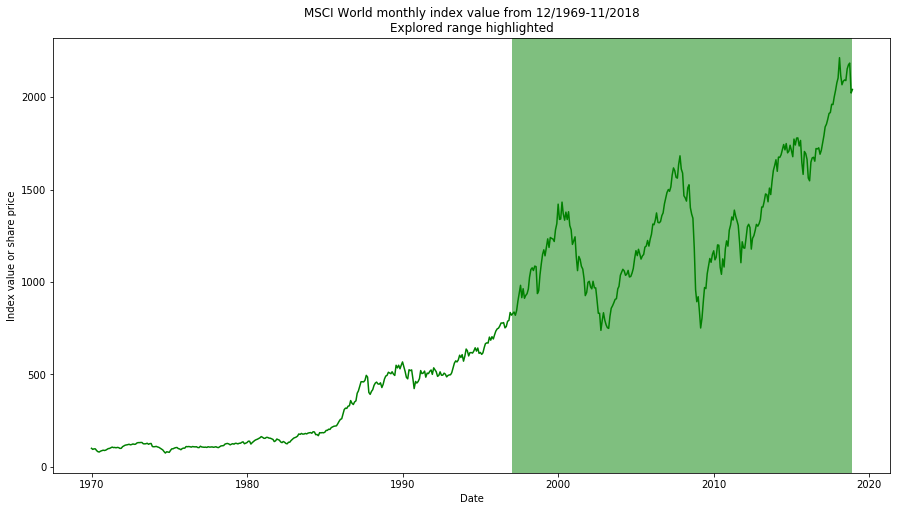

In [177]:
from datetime import date

y_margin = 500
value_max = df_tf["price"].max() + y_margin
value_min = 0 - y_margin/2

#First ordinal in datetime system
ord_0 = date(1, 1, 1).toordinal()

#Dates
x_min = date(first_year, 1, 1).toordinal() - ord_0
x_max = df_tf['date'].max().toordinal() - ord_0
x_days = x_max - x_min

#Initialie plot
fig, ax = plt.subplots(figsize=(15,8))

#Draw value line
ax.plot(df_tf["date"], df_tf["price"], color="green")

#Titles and labels
plt.title("MSCI World monthly index value from 12/1969-11/2018\nExplored range highlighted")
plt.ylabel("Index value or share price")
plt.xlabel("Date")

#Highlight explored range
highlights = []
rect_1 = Rectangle((x_min, value_min), x_days, value_max)
highlights.append(rect_1)
pc = PatchCollection(highlights, facecolor='green', alpha=0.5, edgecolor=None)
ax.add_collection(pc)

#Show
plt.show()


## The simulation

### Simulation

In [178]:
annual_dfs = []

#Loop each starting year
for y in years:    
    #print("Year: {}".format(y))
    
    #Get cumulative sum of values when starting
    first_row = df_tf[(df_tf['year']==y) & (df_tf['month']==month)].iloc[0]
    first_shares = first_row['shares']
    first_shares_cum = first_row['shares_cum']
    first_date = first_row['date']
    first_order = first_row['order']

    #Get only dates after this year
    df_y = df_tf[df_tf['date']>=first_date].copy()
    
    #Calculate KPIs    
    df_y['shares_cum_after'] = df_y['shares_cum'] - first_shares_cum + first_shares
    df_y['shares_cum_before'] = df_y['shares_cum_after'].shift(1)
    df_y['order_y'] = df_y['order'] - first_order + 1
    #Profit = Total sell sell price / Total investment
    df_y['profit_abs'] = (df_y['shares_cum_before'] * df_y['price']) - ((df_y['order_y'] - 1) * inv)
    df_y['profit_rate'] = (df_y['shares_cum_before'] * df_y['price']) / ((df_y['order_y'] - 1) * inv) - 1    
    df_y['profit_rate_annual'] = (df_y['profit_rate']+1) ** (1 / (df_y['order_y']/12/2))-1
    
    #Tag the year when investing started
    df_y['start_y'] = y

            
    #display(df_y.head())
        
    annual_dfs.append(df_y)
        
df_results = pd.concat(annual_dfs)

#Show top rows
display(df_results.head(12))

,date,price,price_cum,shares,shares_cum,year,month,order,shares_cum_after,shares_cum_before,order_y,profit_abs,profit_rate,profit_rate_annual,start_y
335,1997-11-28,926.496,105742.029,1.079335,1846.026025,1997,11,336,1.079335,NaN,1,NaN,NaN,NaN,1997
336,1997-12-31,936.591,106678.620,1.067702,1847.093727,1997,12,337,2.147037,1.079335,2,10.895892,0.010896,0.138878,1997
337,1998-01-30,961.488,107640.108,1.040055,1848.133781,1998,1,338,3.187092,2.147037,3,64.350681,0.032175,0.288332,1997
338,1998-02-27,1025.297,108665.405,0.975327,1849.109108,1998,2,339,4.162419,3.187092,4,267.715833,0.089239,0.670083,1997
339,1998-03-31,1067.354,109732.759,0.936896,1850.046005,1998,3,340,5.099315,4.162419,5,442.774694,0.110694,0.655208,1997
340,1998-04-30,1076.530,110809.289,0.928910,1850.974915,1998,4,341,6.028226,5.099315,6,489.566012,0.097913,0.453021,1997
341,1998-05-29,1061.791,111871.080,0.941805,1851.916720,1998,5,342,6.970031,6.028226,7,400.715990,0.066786,0.248145,1997
342,1998-06-30,1085.737,112956.817,0.921033,1852.837753,1998,6,343,7.891064,6.970031,8,567.620348,0.081089,0.263525,1997
343,1998-07-31,1082.741,114039.558,0.923582,1853.761335,1998,7,344,8.814646,7.891064,9,543.978720,0.067997,0.191755,1997
344,1998-08-31,937.092,114976.650,1.067131,1854.828466,1998,8,345,9.881777,8.814646,10,-739.865668,-0.082207,-0.186070,1997


## Analyze results

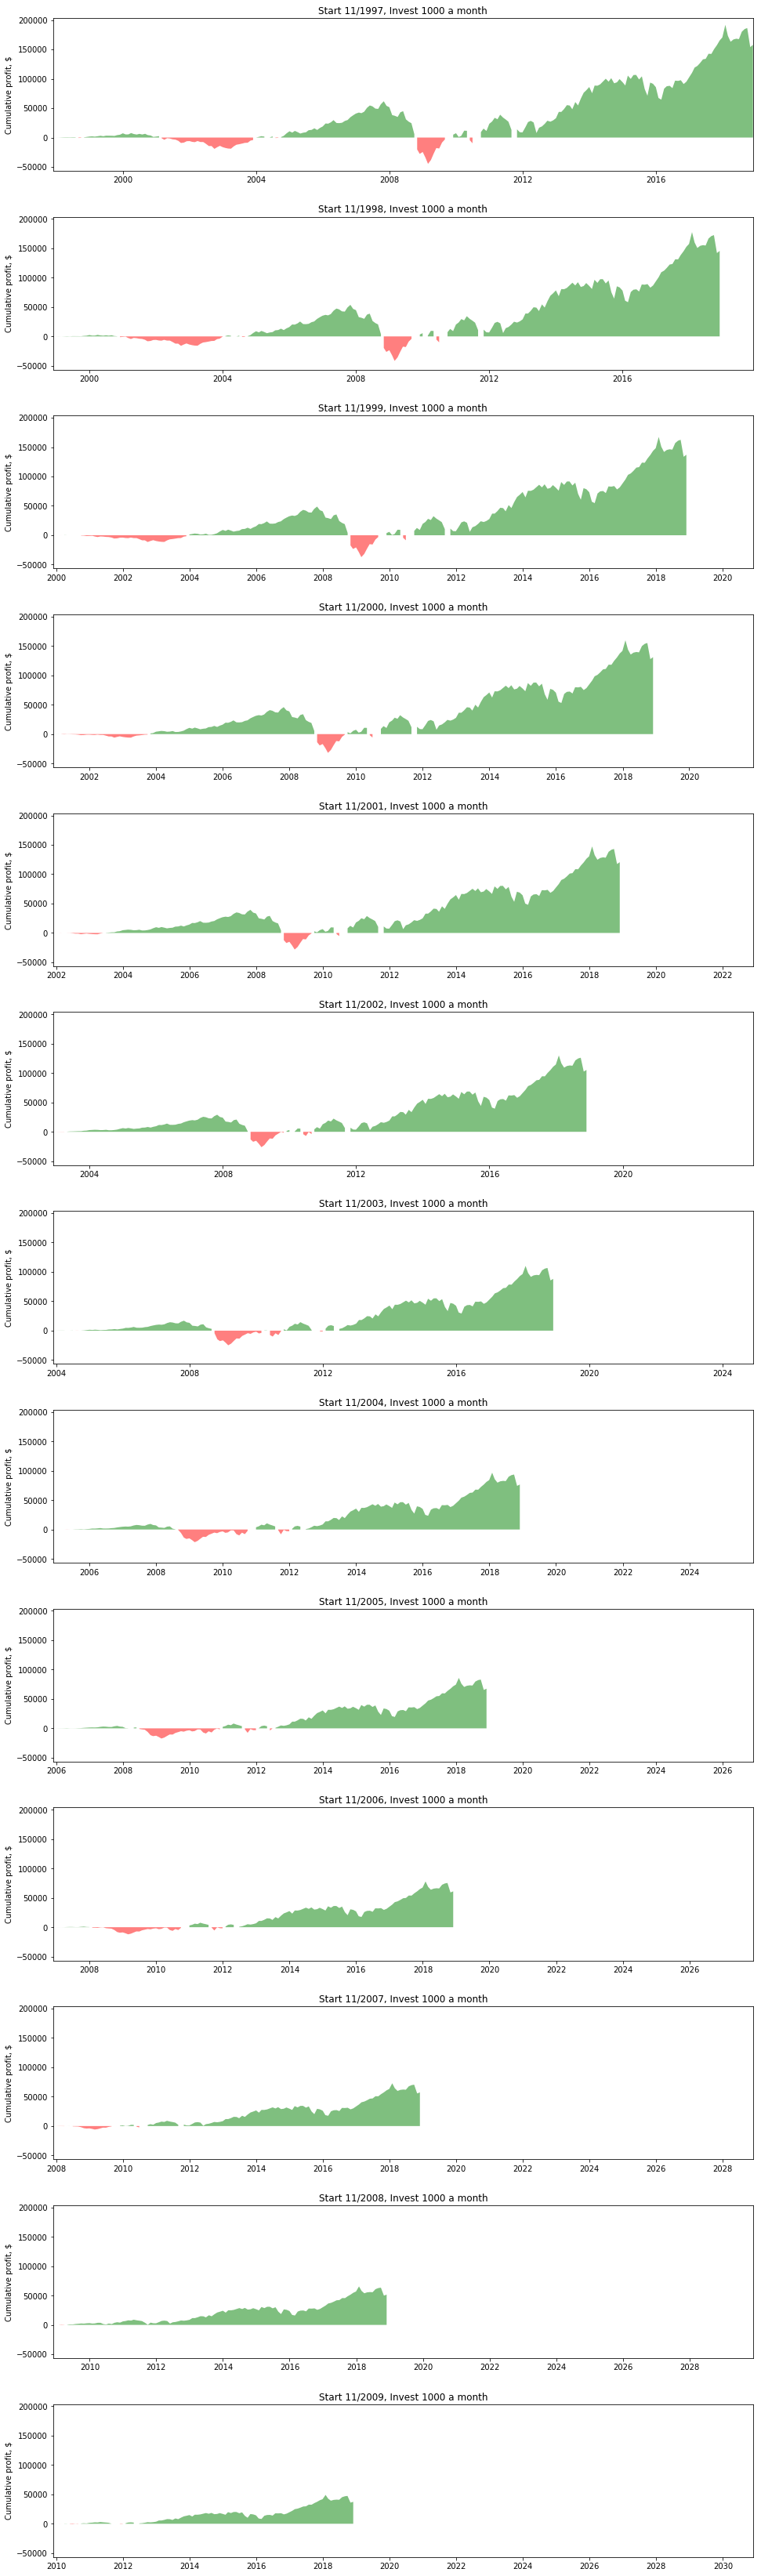

In [179]:
#Initialize plot
n_plots = len(years)
fig, ax = plt.subplots(n_plots, sharey=True, figsize=(16,24))

#Loop and visualize each year
i=0
for y in years:
    
    #Data Frame to visualize the year
    df_yvis = df_results[df_results['start_y']==y]
    
    #Draw the plot
    dates = df_yvis['date'].values.astype('datetime64[D]')
    profit = df_yvis['profit_abs']
    
    #Area chart
    ax[i].fill_between(dates, profit, where=profit<=0, facecolor='r', alpha=0.5)
    ax[i].fill_between(dates, profit, where=profit>=0, facecolor='g', alpha=0.5)
    
    #Subplot title
    ax[i].set_title("Start {}/{}, Invest {}$ a month".format(month, y, inv))
    ax[i].set_ylabel("Cumulative profit, $")
    
    #Subplot y limits
    #ax[i].set_ylim([-50, 100])
    
    #X limits
    x_min = df_yvis['date'].min()
    x_max= df_yvis['date'].max() + np.timedelta64((y - first_year) * 365, 'D')
        
    ax[i].set_xlim(x_min, x_max)
    
    plt.subplots_adjust(top=2, hspace=0.3)
    
    i += 1
    
plt.show()